In [291]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import lmfit
import scipy as sp
import pandas as pd

In [292]:
# import cpp lib for spectrum calculation and initialize argtypes for functions in it

lib = ctypes.CDLL("./getspec.dll", winmode=0)

c_floating = ctypes.c_double;

class c_cfloating(ctypes.Structure): 
    """complex is a c structure
    https://docs.python.org/3/library/ctypes.html#module-ctypes suggests
    to use ctypes.Structure to pass structures (and, therefore, complex)
    """
    _fields_ = [("real", c_floating),("imag", c_floating)]
    @property
    def value(self):
        return self.real+1j*self.imag # fields declared above

c_floating_ptr = ctypes.POINTER(c_floating)
c_cfloating_ptr = ctypes.POINTER(c_cfloating)
c_uint_ptr = ctypes.POINTER(ctypes.c_uint)
c_int = ctypes.c_int

lib.reserve_complex_array.restype = c_cfloating_ptr
lib.reserve_complex_array.argtypes = [ctypes.c_int]
lib.reserve_array.restype = c_floating_ptr
lib.reserve_array.argtypes = [ctypes.c_int]
lib.reserve_twists.restype = c_cfloating_ptr
lib.reserve_twists.argtypes = [ctypes.c_int]
lib.reserve_bitrev.restype = c_uint_ptr
lib.reserve_bitrev.argtypes = [ctypes.c_int]

lib.free_array.restype = None
lib.free_array.argtypes = [c_floating_ptr]
lib.free_complex_array.restype = None
lib.free_complex_array.argtypes = [c_cfloating_ptr]
lib.free_uint_array.restype = None
lib.free_uint_array.argtypes = [c_uint_ptr]


lib.sdeeval.restype = ctypes.c_bool
lib.sdeeval.argtypes = [c_floating_ptr, c_floating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr,
                        c_cfloating_ptr, c_uint_ptr, c_int, c_int, c_int, c_int, c_floating,
                        c_floating, c_floating, c_floating, c_floating, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating]

In [293]:
def read_spectrum_csv(path):
    with open(path, 'r') as file:
        next(file)
        next(file)
        start = int(next(file))
        file.close()
        return pd.read_csv(path, skiprows=start+4, names=["Frequency", "Level"], usecols=[0,1]).to_numpy()

In [825]:
data450X = read_spectrum_csv("../Experiments/25.05.23/X450mA.CSV")
data450Y = read_spectrum_csv("../Experiments/25.05.23/Y450mA.CSV")
freqs450 = data450X[:,0] * 1000
spec450x = data450X[:,1] / 10
spec450y = data450Y[:,1] / 10

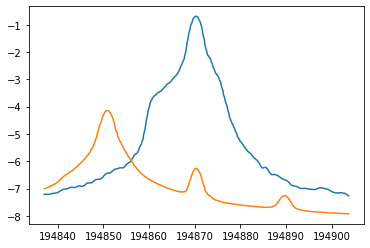

In [295]:
plt.plot(freqs450, spec450x, freqs450, spec450y)

In [1249]:
def residual(params, freqsdatax, freqsdatay, datax, datay, freqsspec, specx, specy):
    # data MUST be provided in logarithmic10 scale
    # specs - in linear
    parvals = params.valuesdict()
    ext_f0 = parvals['f0']
    ext_gamma = parvals['gamma']
    ext_gain = parvals['gain']
    ext_sigma = parvals['sigma']
    fstep = freqsspec[1] - freqsspec[0]
    # spxgauss = sp.interpolate.interp1d(ext_gamma*self.freqs + ext_f0, np.log10(sp.ndimage.gaussian_filter1d(self.spx, ext_sigma / self.fstep / ext_gamma, mode="constant", cval=0.0)))
    # spygauss = sp.interpolate.interp1d(ext_gamma*self.freqs + ext_f0, np.log10(sp.ndimage.gaussian_filter1d(self.spy, ext_sigma / self.fstep / ext_gamma, mode="constant", cval=0.0)))
    # errx = datax - ext_gain - spxgauss(frequencies)
    # erry = datay - ext_gain - spygauss(frequencies)

    # linear
    spxgauss = sp.interpolate.interp1d(ext_gamma*freqsspec + ext_f0, sp.ndimage.gaussian_filter1d(specx*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0))
    spygauss = sp.interpolate.interp1d(ext_gamma*freqsspec + ext_f0, sp.ndimage.gaussian_filter1d(specy*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0))
    errx = 10**datax - spxgauss(freqsdatax)
    erry = 10**datay - spygauss(freqsdatay)
    return np.reshape(np.concatenate([errx, erry]), -1)

def fit_transform(freqsdatax, datax, datay, freqsspec, specx, specy, freqsdatay=None, gamma=None, gain=None, sigma=None):
    if freqsdatay is None:
        freqsdatay = freqsdatax
    mfdx = freqsdatax[np.argmax(datax)]
    mfdy = freqsdatay[np.argmax(datay)]
    mfx = freqsspec[np.argmax(specx)]
    mfy = freqsspec[np.argmax(specy)]
    deltaf = max(np.max(freqsdatax), np.max(freqsdatay)) - min(np.min(freqsdatax), np.min(freqsdatay))
    if abs(mfx - mfy) < 1e-4:
        # TODO : get other maxima
        mfx = freqsspec[np.argmax(specx[0:int(specx.shape[0]/2)])]
        if abs(mfx - mfy) < 1e-4:
            print(mfx)
            print(mfy)
            return True
    parameters = lmfit.create_params(gamma={}, f0={}, gain={}, sigma={})
    if gamma is None:
        parameters['gamma'].set( (mfdy - mfdx) / (mfy - mfx), min=0.0, vary=True )
        if (mfdy - mfdx) / (mfy - mfx) < 0.01:
            return True
    else:
        parameters['gamma'].set( gamma, vary=False)
    f0 = (mfy*mfdx - mfdy*mfx) / (mfy - mfx)
    parameters['f0'].set( value=f0, min=f0-deltaf/4, max=f0+deltaf/4, vary=True )
    if gain is None:
        parameters['gain'].set( (np.max(datax) - np.log10(np.max(specx)) + np.max(datay) - np.log10(np.max(specy))) / 2, vary=True )
    else:
        parameters['gain'].set( gain, vary=False )
    if sigma is None:
        parameters['sigma'].set( 0.9, min=0.0, vary=True )
    else:
        parameters['sigma'].set( sigma , min=0.0, vary=False )
    return lmfit.minimize(residual, parameters, method="leqst_sq", kws={"freqsdatax":freqsdatax, "datax":datax, 
                                                                        "freqsdatay":freqsdatay, "datay":datay, 
                                                                        "freqsspec":freqsspec, "specx":specx, "specy":specy})

def transform(params, freqsspec, specx, specy):
    parvals = params.valuesdict()
    ext_f0 = parvals['f0']
    ext_gamma = parvals['gamma']
    ext_gain = parvals['gain']
    ext_sigma = parvals['sigma']
    return [ext_gamma*freqsspec + ext_f0, 
            sp.ndimage.gaussian_filter1d(specx*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0),
            sp.ndimage.gaussian_filter1d(specy*10**ext_gain, ext_sigma / fstep / ext_gamma, mode="constant", cval=0.0)]

In [509]:
Npow = 16; 
L = 2**Npow;  # number of examined dots

# initialize arrays
twist = lib.reserve_twists(Npow)
bitrev = lib.reserve_bitrev(Npow)
Ex = lib.reserve_complex_array(L)
Ey = lib.reserve_complex_array(L)
tmpEx = lib.reserve_complex_array(L)
tmpEy = lib.reserve_complex_array(L)
specx = lib.reserve_array(L)
specy = lib.reserve_array(L)

In [1336]:
Dt = 1e-6;
tau = 1e-4;
offset = 0.2;
Nav = 3;

tauDt = round(np.floor(tau/Dt));
if tauDt < 1:
    tauDt = 1
tau = tauDt * Dt;  # fix tau in order to make it right value

skip = round(offset * L);  # how many dots will be skipped by offset

freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)
fstep = freqs[1]-freqs[0]

# params = [alpha, kappa, gamma, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel] 
params = [4., 150., 1.0, 826.5, 3.5, 2*np.pi*21, -0.1, 20., 5e-5, 0.95] 


params = [4., 650., 1.0, 5500, 7.5, 2*np.pi*81, -0.1, 60., 5e-5, 0.956329] 

params = [4., 650., 1.0, 4500, 10.5, 2*np.pi*81, -0.07, 60., 5e-5, 0.956329] 


params = [6., 1050., 1.0, 5000, 20.5, 2*np.pi*91, -0.02, 60., 5e-5, 0.956329] 

# Diploma ver
params = [5., 1750., 1.0, 2700, 75.5, 2*np.pi*241, -0.05, 60., 5e-5, 0.956329] 

params = [5., 150., 1.0, 900, 8.5, 2*np.pi*21, -0.02, 60., 2e-6, 0.956329] 
Nav = 10

Ith = 1.2582  # mA
I450 = 4.5
mutilde = I450/Ith
Nrel = (params[7] - mutilde) / (params[7] - 1)
print(Nrel)

0.9563298659101379


In [1337]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt,
            *params);
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

Wall time: 6.14 s


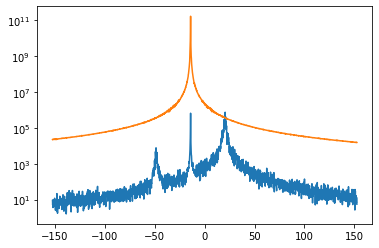

In [1338]:
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], spy[wnd], freqs[wnd], spx[wnd])
plt.yscale("log")

In [1299]:
res = fit_transform(freqs450, spec450y, spec450x, freqs, spx, spy)

In [1300]:
ff, xx, yy = transform(res.params, freqs, spx, spy)

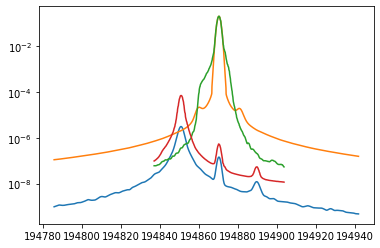

In [1301]:
plt.plot(ff[wnd],xx[wnd], ff[wnd], yy[wnd])
plt.plot(freqs450, 10**spec450x, freqs450, 10**spec450y)
plt.yscale("log")

In [1248]:
res.params

name,value,initial value,min,max,vary
gamma,0.03873871,0.03918856552357391,0.00000000,inf,True
f0,194863.260,194863.25497703615,194846.580,194879.930,True
gain,-9.52719733,-10.987551962806606,-inf,inf,True
sigma,0.90832031,0.9,0.00000000,inf,True


In [1214]:
data345X = read_spectrum_csv("../Experiments/25.05.23/X346mA.CSV")
data345Y = read_spectrum_csv("../Experiments/25.05.23/Y346mA.CSV")
freqs345x = data345X[:,0] * 1000
spec345x = data345X[:,1] / 10
freqs345y = data345Y[:,0] * 1000
spec345y = data345Y[:,1] / 10
I345 = 3.46

In [1215]:
mu345 = (I345/Ith - Nrel) / (1 - Nrel)
params345 = np.copy(params)
params345[7] = mu345

In [1216]:
%%time
lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt,
            *params345);
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

Wall time: 42.6 s


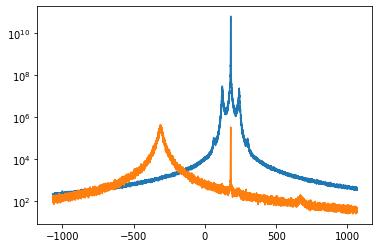

In [1217]:
plt.plot(freqs[wnd], spy[wnd], freqs[wnd], spx[wnd])
plt.yscale("log")

In [1218]:
res345 = fit_transform(freqs345y, spec345y, spec345x, freqs, spx, spy, freqsdatay=freqs345x, 
                       gamma=res.params['gamma'].value, gain=res.params['gain'].value, sigma=res.params['sigma'].value )

In [1219]:
ff345, xx345, yy345 = transform(res345.params, freqs, spx, spy)

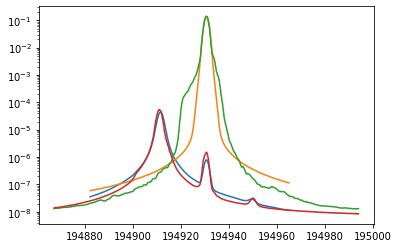

In [1220]:
plt.plot(ff345[wnd],xx345[wnd], ff345[wnd], yy345[wnd])
plt.plot(freqs345x, 10**spec345x, freqs345y, 10**spec345y)
plt.yscale("log")

Other currents
-----------------------

In [1221]:
data233X = read_spectrum_csv("../Experiments/25.05.23/X233mA.CSV")
data233Y = read_spectrum_csv("../Experiments/25.05.23/Y233mA.CSV")
freqs233x = data233X[:,0] * 1000
spec233x = data233X[:,1] / 10
freqs233y = data233Y[:,0] * 1000
spec233y = data233Y[:,1] / 10
I233 = 2.33
mu233 = (I233/Ith - Nrel) / (1 - Nrel)
params233 = np.copy(params)
params233[7] = mu233

lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, tauDt, Dt,
            *params233);
spx = np.ctypeslib.as_array(specx, (L,))
spy = np.ctypeslib.as_array(specy, (L,))

res233 = fit_transform(freqs233y, spec233y, spec233x, freqs, spx, spy, freqsdatay=freqs233x, 
                       gamma=res.params['gamma'].value, gain=res.params['gain'].value, sigma=res.params['sigma'].value )
ff233, xx233, yy233 = transform(res233.params, freqs, spx, spy)

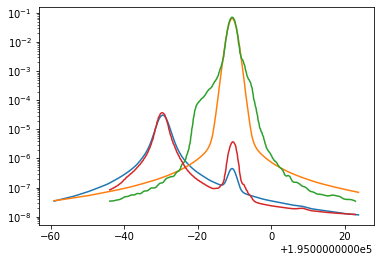

In [1222]:
plt.plot(ff233[wnd],xx233[wnd], ff233[wnd], yy233[wnd])
plt.plot(freqs233x, 10**spec233x, freqs233y, 10**spec233y)
plt.yscale("log")

In [1224]:
mu233

20.506508729718032

In [1339]:
mu345

41.072243815164356

In [1234]:
Nav=3

In [1236]:
# F*CK THIS SH*T
data134X = read_spectrum_csv("../Experiments/25.05.23/X134mA.CSV")
data134Y = read_spectrum_csv("../Experiments/25.05.23/Y134mA.CSV")
freqs134x = data134X[:,0] * 1000
spec134x = data134X[:,1] / 10
freqs134y = data134Y[:,0] * 1000
spec134y = data134Y[:,1] / 10
I134 = 1.34
mu134 = (I134/Ith - Nrel) / (1 - Nrel)
params134 = params
params134[7] = mu134

calc_res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
            twist, bitrev, Npow, skip, Nav, 10*tauDt, 0.001*Dt,
            *params134);
if calc_res:
    spx = np.ctypeslib.as_array(specx, (L,))
    spy = np.ctypeslib.as_array(specy, (L,))

    res134 = fit_transform(freqs134y, spec134y, spec134x, freqs, spx, spy, freqsdatay=freqs134x, 
                           gamma=res.params['gamma'].value, gain=res.params['gain'].value, sigma=res.params['sigma'].value )
    ff134, xx134, yy134 = transform(res134.params, freqs, spx, spy)

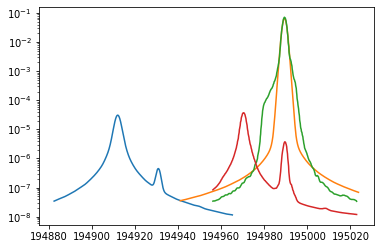

In [1229]:
plt.plot(ff345[wnd],xx233[wnd], ff233[wnd], yy233[wnd])
plt.plot(freqs233x, 10**spec233x, freqs233y, 10**spec233y)
plt.yscale("log")

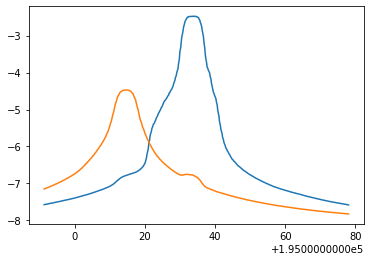

In [1001]:
plt.plot(freqs134x, spec134x, freqs134y, spec134y)

In [1230]:
mu134

2.4887408229995702